# Evaluation on IID Dataset

Installing missing packages

In [15]:
!pip install timm transformers
!pip install torchsummary

Importing necessary libraries


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

# import clip
from transformers import CLIPProcessor, CLIPModel
from PIL import Image


Making the code device agnostic


In [17]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Loading CIFAR-10 dataset from torchvision


In [18]:
# CIFAR-10 dataset loading and transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


## Vision Transformer ViT

In [19]:
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Freeze the feature extractor backbone
for param in vit_model.parameters():
    param.requires_grad = False

# Replace the classifier head with a new head for CIFAR-10 (10 classes)
vit_model.head = nn.Linear(vit_model.head.in_features, 10)
vit_model = vit_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=0.0001)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [20]:
summary(vit_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
           Linear-11             [-1, 197, 768]         590,592
          Dropout-12             [-1, 197, 768]               0
        Attention-13             [-1, 197, 768]               0
         Identity-14             [-1, 1

Finetunining ViT on training data

In [21]:
epochs = 3
train_losses = []

vit_model.train()
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vit_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    accuracy = 100 * correct / total
    print(f'\nEpoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')


100%|██████████| 782/782 [09:27<00:00,  1.38it/s]



Epoch [1/3], Loss: 0.4361, Accuracy: 90.11%


100%|██████████| 782/782 [09:25<00:00,  1.38it/s]



Epoch [2/3], Loss: 0.1240, Accuracy: 96.64%


100%|██████████| 782/782 [09:25<00:00,  1.38it/s]


Epoch [3/3], Loss: 0.0983, Accuracy: 97.07%


### Evaluating the model on test data

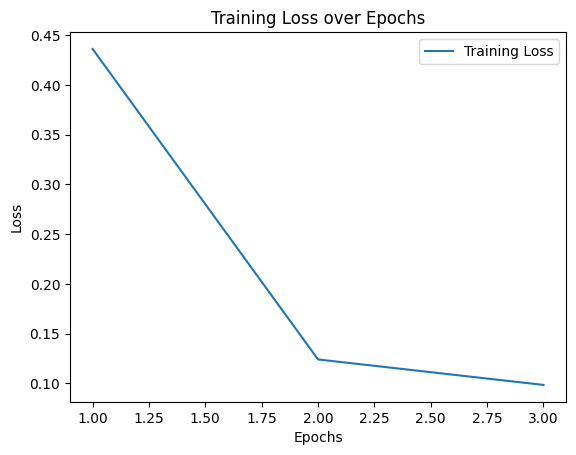

In [22]:
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [23]:
vit_model.eval()
correct = 0
total = 0
loss_total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images)
        loss = criterion(outputs, labels)
        loss_total += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

vit_accuracy = 100 * correct / total
avg_loss = loss_total / len(test_loader)
print(f"\nVision Transformer - Accuracy: {vit_accuracy:.2f}% Loss: {avg_loss:.4f}")

100%|██████████| 157/157 [01:53<00:00,  1.38it/s]


Vision Transformer - Accuracy: 96.71% Loss: 0.1041


## ResNet

In [24]:
resnet_model = timm.create_model('resnet101', pretrained=True)

# Freeze the feature extractor backbone
for param in resnet_model.parameters():
    param.requires_grad = False

# Replace the classifier head with a new head for CIFAR-10 (10 classes)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
resnet_model = resnet_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [25]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
         Identity-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
         Identity-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Finetuning ResNet on training data

In [26]:
epochs = 3
train_losses = []

resnet_model.train()
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    accuracy = 100 * correct / total
    print(f'\nEpoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')

100%|██████████| 782/782 [04:34<00:00,  2.85it/s]



Epoch [1/3], Loss: 1.2047, Accuracy: 69.71%


100%|██████████| 782/782 [04:31<00:00,  2.88it/s]



Epoch [2/3], Loss: 0.7951, Accuracy: 75.08%


100%|██████████| 782/782 [04:31<00:00,  2.88it/s]


Epoch [3/3], Loss: 0.7110, Accuracy: 77.05%


### Evaluating the model on test data

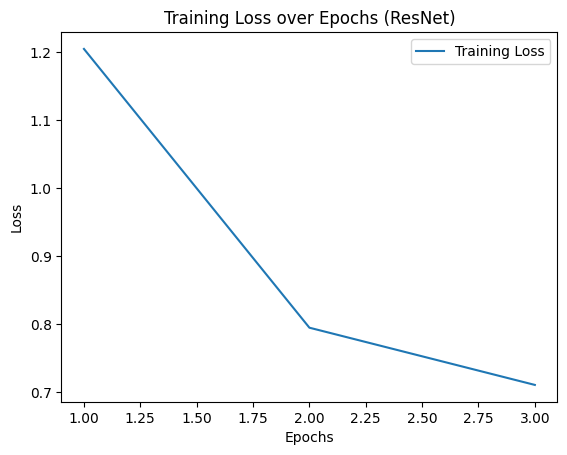

In [27]:
# Plot training loss for ResNet
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (ResNet)')
plt.legend()
plt.show()


In [28]:
# Set the model to evaluation mode
resnet_model.eval()
correct = 0
total = 0
loss_total = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = resnet_model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)
        loss_total += loss.item()

        # Get the predicted class with the maximum score
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy and average loss
resnet_accuracy = 100 * correct / total
avg_loss = loss_total / len(test_loader)

# Print evaluation results
print(f"\nResNet - Accuracy: {resnet_accuracy:.2f}% Loss: {avg_loss:.4f}")


100%|██████████| 157/157 [00:50<00:00,  3.08it/s]


ResNet - Accuracy: 78.32% Loss: 0.6709


## Clip-ViT-Large

Importing pretrained Clip-ViT-Large model

In [29]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
cifar_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

clip_model.eval()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

Class labels for CIFAR-10 dataset

In [30]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

labels = [f"a photo of a {class_name}" for class_name in class_names]

### Evaluating the model on test data

In [32]:
# Zero-shot evaluation on the test dataset with accuracy computation
correct = 0
total = 0

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Evaluating", leave=True):
        images = [img.to(device) for img in images]
        targets = targets.to(device)

        # Process inputs for the CLIP model
        inputs = cifar_processor(text=labels, images=images, return_tensors="pt", padding=True, do_rescale=False).to(device)

        # Forward pass
        outputs = clip_model(**inputs)

        # Get image-text similarity scores
        logits_per_image = outputs.logits_per_image

        # Compute probabilities using softmax
        probs = logits_per_image.softmax(dim=1)

        # Get predicted labels (as indices)
        preds = torch.argmax(probs, dim=1)

        # Calculate accuracy
        correct += (preds == targets).sum().item()
        total += targets.size(0)

accuracy = correct / total * 100
print(f"\nAccuracy: {accuracy:.2f}%")

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Evaluating: 100%|██████████| 157/157 [08:37<00:00,  3.29s/it]


Accuracy: 94.40%
